In [86]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [87]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [88]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect

In [89]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [90]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [91]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [92]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [93]:
# Get the table names from database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [94]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [95]:
# Get a list of column names and types from the 'Station' table
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [96]:
# Get a list of column names and types from the 'measurement' table
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [97]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


In [98]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(date_year_ago)

 

2016-08-23


In [99]:
# Perform a query to retrieve the data and precipitation score
last12 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23', Measurement.date <= '2017-08-23').all()

In [100]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date

df = pd.DataFrame(last12, columns=['date', 'prcp'])
df.set_index('date', inplace=True)
df.rename(columns={'prcp':'precipitation'}, inplace=True)
df=df.sort_values(by='date')
df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


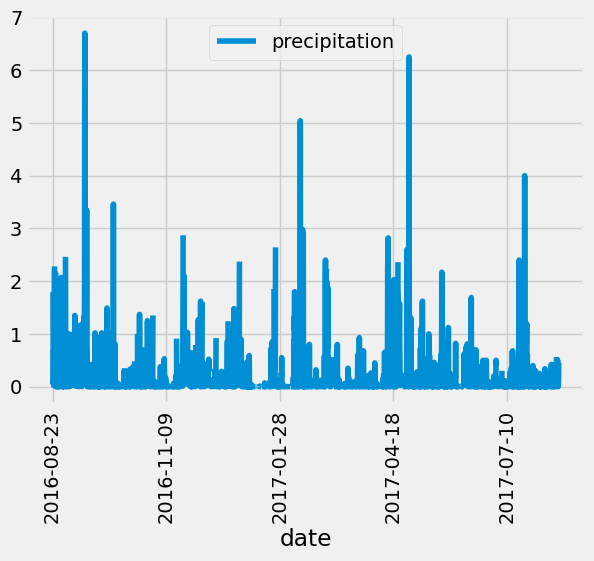

In [101]:
# Use Pandas Plotting with Matplotlib to plot the data

df.plot()
plt.legend()
plt.xticks(rotation = 90)
plt.show()

In [102]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [103]:
# Design a query to calculate the total number of stations in the dataset
Total_Stations = session.query(func.count(Station.id)).all()
Total_Stations

[(9,)]

In [104]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Individual_Station_Count
station_tobs = session.query(Station.station, func.count(Measurement.tobs)).join(Measurement, Station.station==Measurement.station).group_by(Station.station).order_by(func.count(Measurement.tobs).desc()).all()
station_tobs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

So, the station "USC00519281" has the greater number of observations

In [105]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_tobs = session.query(Station.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).join(Measurement, Station.station==Measurement.station).group_by(Station.station).filter(Station.station=='USC00519281').all()
print(f" The most active station, lowest, highest and average temperatures are: {most_active_station_tobs}")

 The most active station, lowest, highest and average temperatures are: [('USC00519281', 54.0, 85.0, 71.66378066378067)]


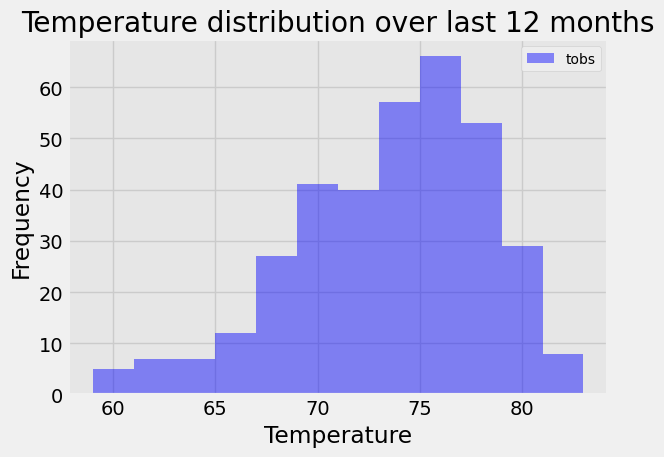

In [106]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last12_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= '2016-08-23', Measurement.date <= '2017-08-23').\
    filter(Measurement.station=='USC00519281').all()
last12_tobs

last12_tobs_df = pd.DataFrame(last12_tobs, columns=['date', 'tobs'])
last12_tobs_df.head(10)

ax = plt.axes(facecolor='#E6E6E6')
ax.set_axisbelow(True)

plt.hist(last12_tobs_df['tobs'], bins=12, alpha=0.45, color='blue')
plt.legend(['tobs'], fontsize=10, loc='upper right')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature distribution over last 12 months')
plt.tight_layout()
plt.show()


# Close Session

In [107]:
# Close Session
session.close()